# Missing Value Estimation

## 1. Data Loading and Exploration

In [17]:
import pandas as pd
import numpy as np
import os

# File paths
data_dir = "../data"

# File names for Missing Data Datasets
missing_data_files = ["MissingData1.txt", "MissingData2.txt", "MissingData3.txt"]

# Load loading datasets into seperate variables
missing_data_datasets = {}


for i in range(len(missing_data_files)):
    # Load training data and label using read_table for whitespace-separated data
    missing_data_datasets[f"missing_data_{i+1}"] = pd.read_table(os.path.join(data_dir, missing_data_files[i]), header=None, sep='\s+')

    # Display basic information for each dataset
    print(f"Untouched Dataset {i+1} - Dimensions: {missing_data_datasets[f'missing_data_{i+1}'].shape}")
    
    # Check for missing values
    missing_count = (missing_data_datasets[f"missing_data_{i+1}"] == 1.00000000000000e+99).sum().sum()
    print(f"Untouched Dataset {i+1} - Missing Values: {missing_count}")

    # Check number of non-missing Value
    nonmissing_count = (missing_data_datasets[f"missing_data_{i+1}"].size - missing_count)
    print(f"Untouched Dataset {i+1} - Non-Missing Values: {nonmissing_count}")
    print("-" * 48)

Untouched Dataset 1 - Dimensions: (242, 14)
Untouched Dataset 1 - Missing Values: 118
Untouched Dataset 1 - Non-Missing Values: 3270
------------------------------------------------
Untouched Dataset 2 - Dimensions: (758, 50)
Untouched Dataset 2 - Missing Values: 3762
Untouched Dataset 2 - Non-Missing Values: 34138
------------------------------------------------
Untouched Dataset 3 - Dimensions: (273, 79)
Untouched Dataset 3 - Missing Values: 17752
Untouched Dataset 3 - Non-Missing Values: 3815
------------------------------------------------


## 2. Visualization of Null Values

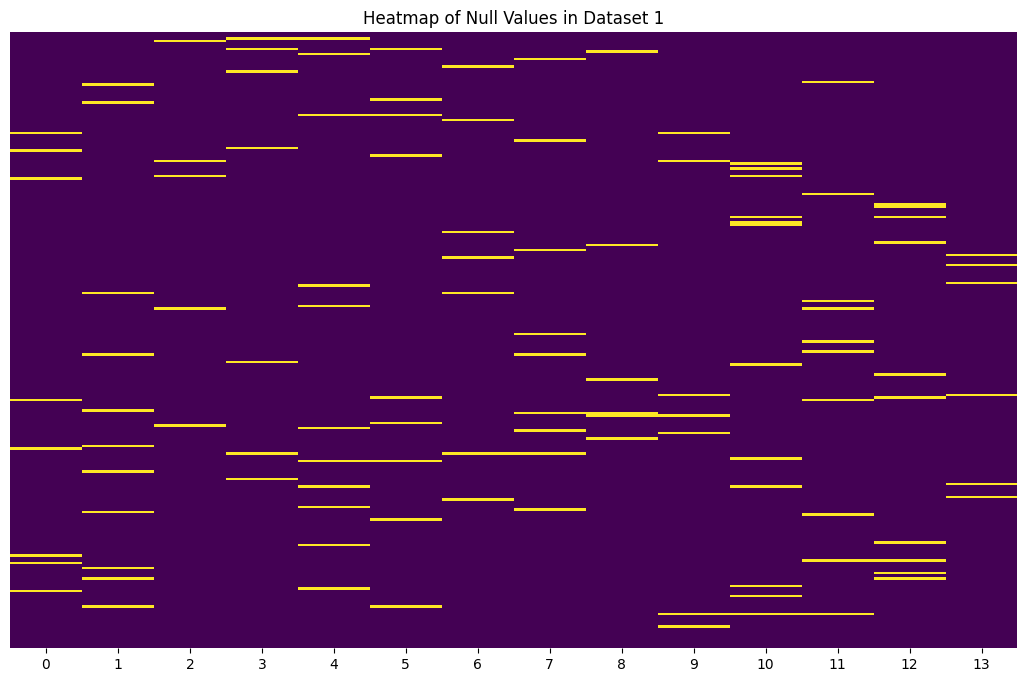

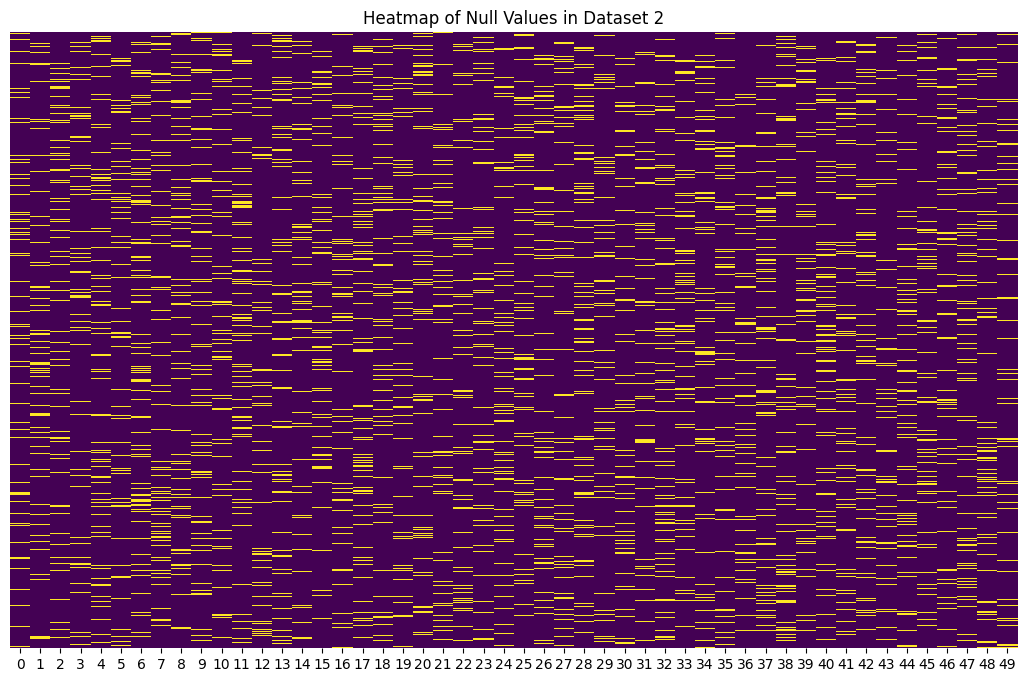

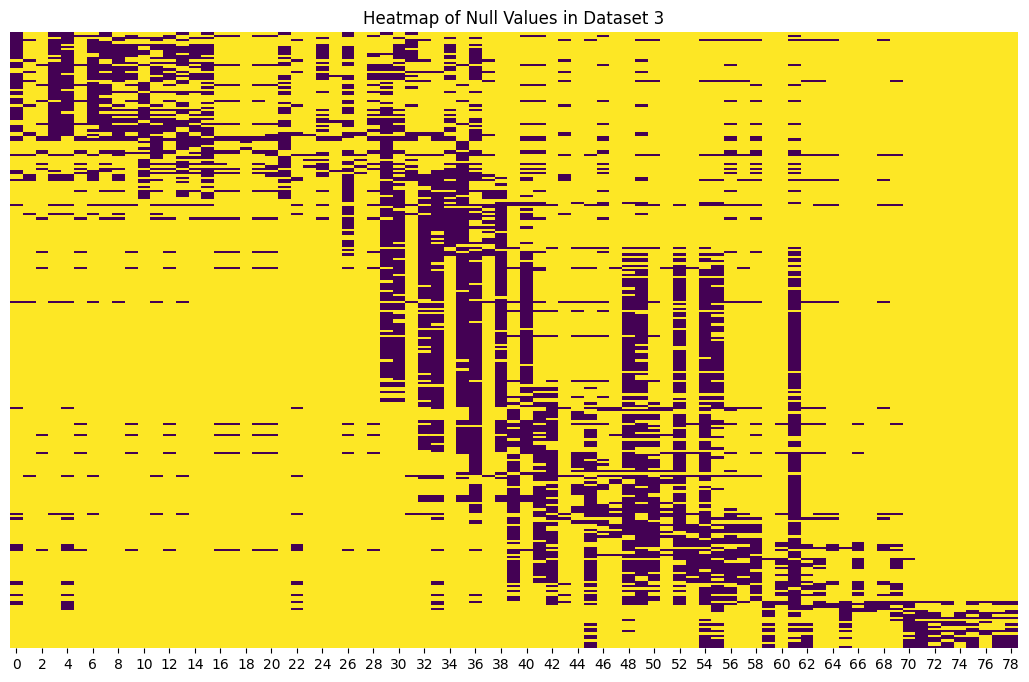

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

for i in range(len(missing_data_files)):
    
    # Create a Heatmap of Null values in the each dataset 
    plt.figure(figsize=(13, 8))
    sns.heatmap(missing_data_datasets[f'missing_data_{i+1}'] == 1.00000000000000e+99, cbar=False, cmap='viridis', yticklabels=False)
    plt.title(f"Heatmap of Null Values in Dataset {i+1}")
    plt.show()


## 3. Cross validating KNN models to determine optimal K for each dataset

In [ ]:
from sklearn.impute import SimpleImputer

# Create a simple imputation of the missing data so it can be used for cross validating KNN models
imputer = SimpleImputer(strategy='mean', missing_values=1.00000000000000e+99)
imputed_data_list = []
for data in missing_data_datasets:
    imputed_data = imputer.fit_transform(missing_data_datasets[data])
    imputed_data_list.append(imputed_data)



from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold


# Parameters
k_values = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]  # List of k values to try
percent_missing_list = [0.04, 0.1, 0.823]
n_splits = 5  # Number of folds for cross-validation
results = {k: [] for k in k_values}
random_seeds = range(10)  # Using seeds 0 to 9
counter = 0

# Loop over each dataset
for data in imputed_data_list:
    # Perform K-Fold Cross-Validation on each dataset
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    

    # Loop over each random seed
    for seed in random_seeds:
        for train_idx, test_idx in kf.split(data):
            # Create a train/test split
            train_data, test_data = data[train_idx], data[test_idx]
            
            # Introduce missingness randomly in the test set for evaluation using the percentage of missing data in the original data sets
            np.random.seed(seed)  # Set a seed for reproducibility
            mask = np.random.rand(*test_data.shape) < percent_missing_list[counter]
            test_data_with_missing = test_data.copy()
            test_data_with_missing[mask] = np.nan
            
            # Loop through each k value
            for k in k_values:
                # Initialize KNNImputer with the current k
                knn_imputer = KNNImputer(n_neighbors=k)
                
                # Perform imputation on the dataset with missing values
                imputed_data = knn_imputer.fit_transform(test_data_with_missing)
                
                # Calculate the mean squared error only on the imputed values
                mse = mean_squared_error(test_data[mask], imputed_data[mask])
                results[k].append(mse)

    # Incriment counter (yes this is sloppy but I dont feel like writing a more elegant solution)
    counter += 1

    # Calculate the average error for each k value across all folds and random seeds
    average_errors = {k: np.mean(results[k]) for k in k_values}

    # Identify the optimal k
    optimal_k = min(average_errors, key=average_errors.get)

    print("Optimal k:", optimal_k)
    print("Average Errors by k:", average_errors)
    print ("-" * 60)


Optimal k: 7
Average Errors by k: {3: np.float64(0.07632921636803303), 4: np.float64(0.07427090175907793), 5: np.float64(0.0737377297360335), 6: np.float64(0.07365634806279413), 7: np.float64(0.07288862122448062), 8: np.float64(0.07309750175883971), 9: np.float64(0.07342906137921934), 10: np.float64(0.07361816746204647), 11: np.float64(0.07358155972916894), 12: np.float64(0.07347510681594324), 13: np.float64(0.07420003905083543), 14: np.float64(0.07505512495759628), 15: np.float64(0.07552569438423609)}
------------------------------------------------------------
Optimal k: 4
Average Errors by k: {3: np.float64(0.10323632854699902), 4: np.float64(0.1012236915681341), 5: np.float64(0.10135988532396047), 6: np.float64(0.10205943903427526), 7: np.float64(0.10228879630931478), 8: np.float64(0.10347336879684949), 9: np.float64(0.10461780308403006), 10: np.float64(0.10572823070357147), 11: np.float64(0.106693258030622), 12: np.float64(0.10753681937119536), 13: np.float64(0.10887117756619304),

It can be concluded from the above tests that, if we were use KNN imputers for these three data sets to impute the missing values, the optimal K Values would be 7, for the first data set, 4, for the second, and 9 for the third dataset. 

However, it is also fairly clear that KNN is a suboptimal method for imputing missing values in the third dataset regardless of this testing, as the error seen in this dataset is MUCH greater than that present in the first two. 
This is unsurprising as the 3rd dataset is comprised of over 80 percent missing data and this method of simple imputation and masking is bound to work suboptimally. 
This is all not to mention that the missing data in dataset 3 doesnt seem to be randomly distributed in the first place, meaning this testing method is somewhat invalid for this dataset in particular.

## 4. Run KNN Imputation on the first 2 datasets 

In [28]:
knn_imputer_ds1 = KNNImputer(n_neighbors = 7, missing_values = 1.00000000000000e+99)
KNNImputed_dataset_1 = knn_imputer_ds1.fit_transform(missing_data_datasets[f'missing_data_1'])

knn_imputer_ds2 = KNNImputer(n_neighbors = 4, missing_values = 1.00000000000000e+99)
KNNImputed_dataset_2 = knn_imputer_ds2.fit_transform(missing_data_datasets[f'missing_data_2'])